In [27]:
# !git clone https://github.com/RIPS-2024-Aerospace/Aerospace-Project.git

fatal: destination path 'Aerospace-Project' already exists and is not an empty directory.


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

np.random.seed(163)

# replace with file paths
# %run "DiffKf.ipynb"
# %run "KF.ipynb"
%run "/content/Aerospace-Project/Standard Filters/DiffKf.ipynb"
%run "/content/Aerospace-Project/Standard Filters/KF.ipynb"

In [29]:
dt = 10

C = np.array([[0.34,0.33, 0, 0, 0.33],[0.33,0.34,0.33,0,0],[0,0.33,0.34,0.33,0],[0,0,0.33,0.34,0.33],[0.33,0,0,0.33,0.34]])
C_unweighted = np.array([[1 if x!=0 else 0 for x in row] for row in C])

num_stns = len(C[0])

A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],[0,0,1,0]])

dkf_state_size = len(A)
dkf_measure_size = len(H)

q = 0.001
Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]])
R = np.array([[4,0],[0,4]])

A_kf = np.kron(np.eye(num_stns),A)
H_kf = np.kron(np.eye(num_stns),H)
Q_kf = np.kron(np.eye(num_stns),Q)
R_kf = np.kron(np.eye(num_stns),R)

kf_state_size = A_kf.shape[0]
kf_measure_size = R_kf.shape[0]

F = [A for _ in range(num_stns)]
G = [np.eye(dkf_state_size) for _ in range(num_stns)]
H_dkf = [H for _ in range(num_stns)]

Q_dkf = [Q for _ in range(num_stns)]
R_dkf = [R for _ in range(num_stns)]

In [30]:
procc_noise_kf = lambda : np.linalg.cholesky(Q_kf) @ np.random.normal(np.array([[0 for _ in range(kf_state_size)]]).T)
measure_noise_kf = lambda : np.linalg.cholesky(R_kf) @ np.random.normal(np.array([[0 for _ in range(kf_measure_size)]]).T)

measure_kf_to_dkf  = lambda z: [np.array([z[dkf_measure_size*i + j] for j in range(dkf_measure_size)]) for i in range(num_stns)]
state_kf_to_dkf = lambda z: [np.array([z[dkf_state_size*i + j] for j in range(dkf_state_size)]) for i in range(num_stns)]

In [31]:
#True Initial
x0_kf = np.array([[np.random.normal(0,np.sqrt(Q_kf[i,i])) for i in range(kf_state_size)]]).T


#Initial Estimate
x_kf = np.array([[np.random.normal(0,5) for i in range(kf_state_size)]]).T
x_dkf = state_kf_to_dkf(x_kf)


P_kf = 10*np.copy(Q_kf)
P_dkf = [10*np.copy(Q) for _ in range(num_stns)]

kf = KalmanFilter(A = A_kf,H = H_kf, Q = Q_kf, R = R_kf,P=P_kf,x0=x_kf)

dkf = DiffKF(C,F,G,H_dkf,R_dkf,Q_dkf,x_dkf,P_dkf)

In [78]:


def get_diff_cov(C, prev_cov, Station_cov):
    num_stns = len(C)
    dkf_state_size = prev_cov.shape[0] // num_stns
    dt = 10
    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
    G = np.eye(dkf_state_size)
    Q = 0.001 * np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0], [0, 0, (dt**3)/3, (dt**2)/2], [0, 0, (dt**2)/2, dt]])
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    R = np.array([[4, 0], [0, 4]])

    S = lambda i: np.sum([H.T @ np.linalg.inv(R) @ H for _ in range(num_stns)], axis=0)

    S_full = np.block([[np.zeros(A.shape) if i != j else S(j) for j in range(num_stns)] for i in range(num_stns)])
    H_full = np.kron(np.eye(num_stns), H)
    P_full = np.block([[np.zeros(Station_cov[0].shape) if i != j else Station_cov[j] for j in range(num_stns)] for i in range(num_stns)])
    R_full = np.kron(np.eye(num_stns), R)

    C_full = np.kron(C, np.eye(dkf_state_size))
    A_full = np.kron(np.eye(num_stns), np.eye(dkf_state_size))

    # Compute the covariance (equation 32)
    F_i = C_full.T @ (np.eye(S_full.shape[1]) - (P_full @ S_full)) @ np.kron(np.eye(num_stns), A)
    G_i = C_full.T @ (np.eye(S_full.shape[1]) - (P_full @ S_full)) @ np.kron(np.eye(num_stns), G)
    D_i = C_full.T @ P_full @ A_full.T @ H_full.T @ np.linalg.inv(R_full)

    term1 = F_i @ prev_cov @ F_i.T
    term2 = G_i @ np.kron(np.ones((num_stns, num_stns)), Q) @ G_i.T
    term3 = D_i @ R_full @ D_i.T

    return term1 + term2 + term3

In [80]:

iters = 60

truth = np.zeros((iters+1,kf_state_size,1))
truth[0] = x0_kf

measurements = np.zeros((iters+1,kf_measure_size,1))
measurements[0] = (H_kf @ x0_kf)+measure_noise_kf()


predictions_kf = np.zeros((iters,kf_state_size,1))
predictions_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

errors_kf = np.zeros((iters,kf_state_size,1))
errors_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

P_hist_kf = np.zeros((iters,kf_state_size,kf_state_size))
P_hist_dkf = np.zeros((iters, num_stns, dkf_state_size,dkf_state_size))


full_system_P_hist = np.zeros((iters,kf_state_size,kf_state_size))
prev_cov = np.block([[np.zeros(P_dkf[0].shape) if i!= j else dkf.nodes[i].P for j in range(num_stns)] for i in range(num_stns)])


for i in range(iters):

    kf.update(measurements[i])
    dkf.update(measure_kf_to_dkf(measurements[i]))

    predictions_dkf[i] = [dkf.nodes[j].x for j in range(num_stns)]
    errors_dkf[i] = [dkf.nodes[j].x-state_kf_to_dkf(truth[i])[j] for j in range(num_stns)]
    station_covs = [dkf.nodes[j].P for j in range(num_stns)]
    P_hist_dkf[i] = station_covs

    prev_cov = get_diff_cov(C, prev_cov, station_covs)
    full_system_P_hist[i] = prev_cov


    predictions_kf[i] = kf.x
    errors_kf[i] = kf.x-truth[i]
    P_hist_kf[i] = kf.P


    kf.predict()
    dkf.predict()

    truth[i+1] = A_kf@x0_kf + procc_noise_kf()
    measurements[i+1] = H_kf @ truth[i+1] + measure_noise_kf()


In [81]:
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    # mu1 = mean of diffusion KF
    # mu2 = mean of centralized KF
    # Sigma1 = covariance of diffusion KF
    # Sigma2 = covariance of centralized KF
    Sigma = (Sigma1 + Sigma2) / 2
    inv_Sigma = np.linalg.inv(Sigma)

    term1 = 1/8 * np.dot(np.dot((mu1 - mu2).T, inv_Sigma), (mu1 - mu2))
    term2 = 1/2 * np.log(np.linalg.det(Sigma) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))

    return term1 + term2

In [82]:
# Distance between CKF and DKF for this example
mu1 = np.zeros(kf_state_size,int)
mu2 = np.zeros(kf_state_size, int)
Sigma1 = P_hist_kf[40]
Sigma2 = full_system_P_hist[40]
bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2)

22.720694903342665

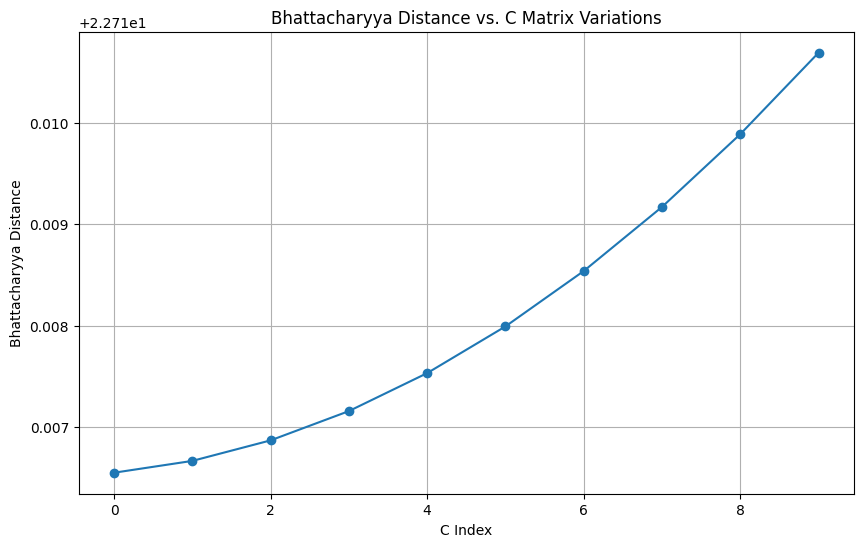

In [84]:
# since the means are 0, I'm getting rid of the first term
def bhattacharyya_distance(Sigma1, Sigma2):
    Sigma_mean = (Sigma1 + Sigma2) / 2
    term1 = np.log(np.linalg.det(Sigma_mean) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2))) / 2
    return term1

# input covariances have been chosen ARBITARILY
prev_cov = full_system_P_hist[39]  # replace with covariance matrix of the 39th step in diff KF
Station_cov = P_hist_dkf[40]  # replace with covariance matrix of the 40th step in diff KF
reference_cov = P_hist_kf[40]  # replace with covariance matrix of CKF

# change the second and last value equally to maintain row stochasticity
C_values = [np.array([[0.34 , 0.33 + 0.01 * i, 0, 0, 0.33 - (0.01 * i)], [0.33, 0.34, 0.33, 0, 0], [0, 0.33, 0.34, 0.33, 0], [0, 0, 0.33, 0.34, 0.33], [0.33, 0, 0, 0.33, 0.34]]) for i in range(10)]

# Compute the Bhattacharyya distance for each C value
distances = []
for C in C_values:
    cov = get_diff_cov(C, prev_cov, Station_cov)
    distance = bhattacharyya_distance(cov, reference_cov)
    distances.append(distance)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(C_values)), distances, marker='o')
plt.xlabel('C Index')
plt.ylabel('Bhattacharyya Distance')
plt.title('Bhattacharyya Distance vs. C Matrix Variations')
plt.grid(True)
plt.show()
